<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: This notebook is still a work in progress & will be updated soon

# Milestone Project 1: Food Vision

- Training a big dog model with all of the images
- Trying to beat DeepFood paper: https://arxiv.org/pdf/1606.05675.pdf (top-1 accuracy of 77.4%)
- Use feature extraction then straight into fine-tuning
- The exercises are to evaluate the model like we did in notebook 01


## TODO:

* Clean up data loading
* Clean up headings
* Clean model loading code (remove excess cell outputs)
* Use mixed precision for fine-tuning (if you don’t, your models will take 2.5x longer to train)
* Upload trained models to GS so a student can download the trained version and use it
* Make sure mixed precision works with the saved & loaded model

In [1]:
!nvidia-smi

Fri Mar  5 06:37:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

1. Get data ready (download).
2. Prepare the data (load with `image_dataset_from_directory`).
3. Choose and fit/train a model (tf.keras.applications, create callbacks with TensorBoard, Learning rate lowering, EarlyStopping and model checkpointing).
4. Evalute model predictions (with metrics and testing on sample images).
5. Make sure model can be saved and reloaded.
6. Discuss possible model improvements...

## TK Get helper functions

Functions we've made before... 

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-03-05 06:37:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-03-05 06:37:05 (89.9 MB/s) - ‘helper_functions.py.2’ saved [9304/9304]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## TK - Download data (using TensorFlow Datasets)

Let's start by downloading the data. Since it's in a compressed format, we'll have to unzip it.

> 🔑 **Note:** The data we're downloading is the entire [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home) with 101,000 images of 101 types of different foods (750 training images and 250 testing images for each class) from the original [Food101 - Mining Discriminative Components with Random Forests](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) paper. Some preprocessing has been done to the data to get it into standard image classification format, see the Food Vision Image Preprocessing notebook to see how this was done (TK - add in food vision image preprocessing notebook link). 

## TK - Use TensorFlow Datasets to Download Data

TensorFlow Datasets - https://www.tensorflow.org/datasets/overview

TK - Why use TensorFlow Datasets?
* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

In [4]:
# TK - get data from TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
# List available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list) # is the dataset we're after available?

True


Splits info for `split` parameter - https://github.com/tensorflow/datasets/blob/master/docs/splits.md

In [6]:
# Load in the data (takes about 5-6 minutes)
(train_data, test_data), ds_info = tfds.load("food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True,
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True)

TK - Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" parameter (using the `as_supervised=True` parameter in the `tfds.load()` method).

In [7]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### TK - Exploring the Food101 data from TensorFlow Datasets

In [8]:
# Take one sample off the training data
train_one = train_data.take(1) # samples are in format (image_tensor, label)

In [9]:
# Output info about our training sample
for image, label in train_one:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Image label (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image label (tensor form): 77
  Class name (str form): pork_chop
        


In [10]:
# What does the image tensor look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

### TK Plot an image from TensorFlow Datasets

Want:
- take an image tensor from TensorFlow Datasets version of Food101 and plot it to see what it looks like 

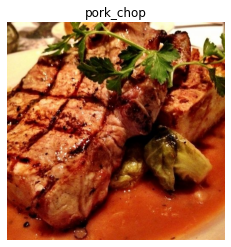

In [10]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## TK Turn image and label tensors into batches for fitting

Our data:
- uint8
- all different size tensors
- not scaled (between 0 & 255)

Models like:
- float32 data
- scaled data (between 0 & 1), also called normalized
- same size tensors (batches require all tensors of same shape, e.g. all images in (224, 224, 3))

TK **Note:** EfficientNetBX models in TensorFlow have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocessing()`" function (like the one below) or within your model as a `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

In [11]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (image, label) tuple

In [12]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image}, shape: {image.shape}\n")
print(f"Image after preprocessing:\n {preprocessed_img}, shape: {preprocessed_img.shape}")

Image before preprocessing:
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]

 [[ 71  35  19]
  [ 65  29  13]
  [ 61  26   7]
  ...
  [162 118  93]
  [144 102  78]
  [137  95  71]]

 ...

 [[210  82  21]
  [208  80  19]
  [205  77  14]
  ...
  [223 172 115]
  [226 175 118]
  [224 173 116]]

 [[199  71   8]
  [199  71   8]
  [198  70   7]
  ...
  [224 173 116]
  [226 175 118]
  [223 172 115]]

 [[204  76  13]
  [204  76  13]
  [203  75  12]
  ...
  [225 174 117]
  [225 174 117]
  [221 170 113]]], shape: (512, 512, 3)

Image after preprocessing:
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  

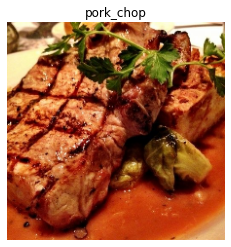

In [13]:
# We can still plot our preprocessed image as long as we divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

All this food visualization is making me hungry. How about we start preparing to model it?

## TK - Batch & prepare datasets

See: https://www.tensorflow.org/guide/data_performance

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first)
- Can't use `cache()` unless your dataset can fit in memory
- `num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- `prefetch()` helps to increase speed too (get one databatch ready whilst the other is being computing on)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)

Steps to go through:
* `map()` - what does?
* `shuffle()` - what does?
* `batch()` - what does?
* `prefetch()` - what does?
* Extra: `cache()` (if your dataset is small enough to fit in memory... or you have lots of RAM, Colab only has 12GB of RAM) 

TK - don't need to shuffle test data... 

In [14]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (and don't shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## TK - Create modelling callbacks

Since we're going to be training on a fairly large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later.
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it.

We'll wrap the `TensorBoard` callback in a function to track the timestamp of our model's training logs as well as a few details about the training itself.

In [16]:
## TK - Already have "create_tensorboard_callback()" from a previous notebook

# Create TensorBoard callback to save model training logs with timestamps and experiment name
# import datetime
# def create_tensorboard_callback(dir_name, experiment_name):
#   log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#   tensorboard_callback = tf.keras.callbacks.TensorBoard(
#       log_dir=log_dir
#   )
#   print(f"Saving TensorBoard log files to: {log_dir}")
#   return tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

## TODO - Try mixed precision training

Mixed precision training = faster model training with same results!!!! (save time)

See: https://www.tensorflow.org/guide/mixed_precision

**Note:** If your GPU doesn't have a score of over 7 (e.g. P100 in Colab), mixed precision won't work (see: "Supported Hardware": https://www.tensorflow.org/guide/mixed_precision#supported_hardware)

In [17]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [18]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

## TK - Build and fit feature-extraction model

Callbacks ready to roll, let's set up a feature-extraction model.

To do so, we'll:
* Use `EfficientNetB0` from `tf.keras.applications` pre-trained on ImageNet as our base model.
  * We'll download this without the top layers using `include_top=False` so we can create our own output layers.
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet.
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/).
* Compile the Functional model using the Adam optimizer and categorical crossentropy as the loss function.
* Fit the model for 5 epochs using the TensorBoard and ModelCheckpoint callbacks.

TK - our model needs a separate output layer (softmax with dtype=float32) so we can use mixed precision for fine-tuning

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) # want one output neuron per class 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [20]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [23]:
for layer in model.layers:
  # layer.dtype = "mixed_float16"
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer True <Policy "float32">
efficientnetb0 False <Policy "mixed_float16">
pooling_layer True <Policy "mixed_float16">
dense True <Policy "mixed_float16">
softmax_float32 True <Policy "float32">


In [24]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers:
  # layer.dtype = "mixed_float16"
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

Now that's one good looking model. Let's fit it to our data shall we?

Five epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [25]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210305-064027
Epoch 1/3
2368/2368 [==============================] - 200s 69ms/step - loss: 2.3304 - accuracy: 0.4656 - val_loss: 1.2252 - val_accuracy: 0.6806
Epoch 2/3
2368/2368 [==============================] - 155s 65ms/step - loss: 1.3210 - accuracy: 0.6614 - val_loss: 1.1201 - val_accuracy: 0.7026
Epoch 3/3
2368/2368 [==============================] - 157s 66ms/step - loss: 1.1445 - accuracy: 0.7040 - val_loss: 1.0798 - val_accuracy: 0.7063


Nice, looks like our feature extraction model is performing pretty well. How about we evaluate it on the whole test dataset?

In [26]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract = model.evaluate(test_data)
results_feature_extract

790/790 [==============================] - 54s 68ms/step - loss: 1.0878 - accuracy: 0.7069


[1.0877856016159058, 0.7069306969642639]

And since we used the `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.

Let's load it in and make sure it performs just as well.

TK - update checkpoint path to save .cpkt and then load .cpkt...

In [30]:
# Load model from saved version, the checkpointed version and then evaluate
loaded_checkpoint_model = model.load_weights(checkpoint_path)

In [32]:
new_model = tf.keras.models.clone_model(model)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [33]:
new_model.load_weights(checkpoint_path)

In [35]:
new_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

In [36]:
new_model.evaluate(test_data)

790/790 [==============================] - 47s 57ms/step - loss: 1.0942 - accuracy: 0.7022


[1.0877861976623535, 0.7069306969642639]

In [37]:
# Check the layers in the base model and see what dtype policy they're using
for layer in new_model.layers[1].layers:
  # layer.dtype = "mixed_float16"
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <P

In [ ]:
# Check loaded model performance
results_loaded_checkpoint_model = loaded_checkpoint_model.evaluate(test_data)

790/790 [==============================] - 88s 111ms/step - loss: 1.2089 - accuracy: 0.6749


We can also save the whole model using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

In [38]:
# Save model to drive for loading later
save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract/"
# os.makedirs(save_dir) # Make directory if it doesn't exist

In [39]:
# Save model
model.save(save_dir)

# # Could also copy our model checkpoints to Drive for later use
# !cp -r model_checkpoint/ drive/My\ Drive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract/

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract/assets


And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

TK - add code for downloading a model from GS and using it in this notebook

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [41]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers:
  # layer.dtype = "mixed_float16"
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [34]:
# Check loaded model performance
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 51s 64ms/step - loss: 1.0658 - accuracy: 0.7117


[1.0657503604888916, 0.7117227911949158]

In [35]:
# The loaded model  should equal (or at least be very close)
# Note: this will only work if you've instatiated results objects
assert results_feature_extract == results_loaded_saved_model

AssertionError: ignored

In [37]:
import numpy as np
np.isclose(results_feature_extract, results_loaded_saved_model)

array([ True,  True])

That's what we want! Our loaded model performing as it should.

> 🔑 **Note:** We spent a fair bit of time making sure our model saved correctly because training on a lot of data can be time-consuming, so we want to make sure we don't have to continaully train from scratch.

## Fine-tuning

Our feature-extraction model is showing some great promise after five epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning.

In fact, let's set ourselves a challenge to beat the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf). Reading through it, it seems they were able to achieve 77.4% top-1 accuracy on the test set.

To start, let's load in our saved model.

> 🔑 **Note:** It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data (feature extraction). And then unfreeze a number or all of the layers in the base model and continue training until the model stops improving.

In [ ]:
# # Load in saved model for fine-tuning
# import tensorflow as tf
# model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract",
#                                    compile=False) # don't compile on load

And now let's make sure our loaded model is performing as expected.

In [71]:
# How does the loaded model perform?
model.evaluate(test_data)

141/790 [====>.........................] - ETA: 41s - loss: 1.0799 - accuracy: 0.7042

KeyboardInterrupt: ignored

Great, our loaded model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting `base_model.trainable=False` but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [66]:
# Are any of the layers in our model frozen?
for layer in model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True


In [42]:
# Are any of the layers in our model frozen?
for layer in loaded_saved_model.layers:
  # layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True


Alright, it seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model?

> 🤔 **Question:** *Which layer in the loaded model is our base model?*

Before saving the Functional model to file, we created it with five layers (layers below are 0-indexed):
0. The input layer.
1. The pre-trained base model layer (`tf.keras.applications.EfficientNetB0`).
2. The pooling layer.
3. The fully-connected (dense) layer.
4. The output softmax activation.

Therefore to inspect our base model layer, we can access the `layers` attribute of the layer at index 2 in our model.

In [67]:
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

In [69]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
              metrics=["accuracy"])

TK - looks like saving and loading a model turns off mixed precision... even resetting the global policy doesn't help our model
  * Might have to can saving a model in between different datatype policies

In [43]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers:
  # layer.dtype = "mixed_float16"
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

Wonderful, it looks like each layer in our base model is trainable (unfrozen). Since we've got so much data (750 images per training class), let's keep it that way.

> 🔑 **Note:** If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 images, which means our model's training time is probably going to be much longer than before.

> 🤔 **Question:** *How long does training take?*

It could be a couple of hours or in the case of the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training.

> 🤔 **Question:** *When do you stop training?*

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training. 

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [44]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

Excellent. If you're planning on training large models, the `ModelCheckpoint` and `EarlyStopping` are two callbacks you'll want to become very familiar with. 

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: [`ReduceLROnPlateau`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau).

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder)

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateua` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

> 🤔 **Question:** *Why lower the learning rate?*

Imagine having a coin at the back of the couch and you're trying to grab with your fingers. Now think of the learning rate as the size of the movements your hand makes towards the coin. The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called **convergence**), we want the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss just like the `EarlyStopping` callback. Once the validation loss stops improving for 3 or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [45]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

Learning rate reduction ready to go!

Now before we start training, we've got to recompile our model.

We'll use categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (`1e-4` instead of `1e-3`). 

In [46]:
# Compile the model
loaded_saved_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
              metrics=["accuracy"])

Okay, model compiled.

Now let's fit it on all of the data. We'll set it up to run for up to 100 epochs. But since we're going to be using the `EarlyStopping` callback, it might use all 100.

> 🔑 **Note:** Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs).

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


# TK Upload model to GS and make available for download 

## TK NOTE: Mixed precision helps an outstanding amount with fine-tuning (the more model parameters you have, the more mixed precision seems to help)

In [51]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [48]:
loaded_saved_model.layers

In [47]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers:
  # layer.dtype = "mixed_float16"
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientB0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientB0_101_classes_all_data_fine_tuning/20210305-065748
Epoch 1/100
2368/2368 [==============================] - 305s 124ms/step - loss: 0.9746 - accuracy: 0.7371 - val_loss: 0.8110 - val_accuracy: 0.7738
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/100
1637/2368 [===================>..........] - ETA: 1:27 - loss: 0.5801 - accuracy: 0.8405

In [ ]:
# Evaluate mixed precision trained loaded model
loaded_saved_model.evaluate(test_data) 

In [ ]:
# ## Model with no mixed_precision...
# Saving TensorBoard log files to: training_logs/efficientB0_101_classes_all_data_fine_tuning/20210305-060748
# Epoch 1/100
#  388/2368 [===>..........................] - ETA: 11:22 - loss: 0.9571 - accuracy: 0.7410

TK (fix what fine-tuning looks like) Fine-tuning results should look something like this:
```
Saving TensorBoard log files to: training_logs/efficientB0_101_classes_all_data_fine_tuning/20200928-013008
Epoch 1/100
   1/2368 [..............................] - ETA: 0s - loss: 1.1452 - accuracy: 0.7188WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2368/2368 [==============================] - ETA: 0s - loss: 1.2068 - accuracy: 0.6820
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
2368/2368 [==============================] - 1397s 590ms/step - loss: 1.2068 - accuracy: 0.6820 - val_loss: 1.1623 - val_accuracy: 0.6894
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9459 - accuracy: 0.7444INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
2368/2368 [==============================] - 1193s 504ms/step - loss: 0.9459 - accuracy: 0.7444 - val_loss: 1.1549 - val_accuracy: 0.6872
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.7838INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
2368/2368 [==============================] - 1143s 482ms/step - loss: 0.7848 - accuracy: 0.7838 - val_loss: 1.0402 - val_accuracy: 0.7142
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.8149INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
2368/2368 [==============================] - 1127s 476ms/step - loss: 0.6599 - accuracy: 0.8149 - val_loss: 0.9599 - val_accuracy: 0.7373
Epoch 5/100
2368/2368 [==============================] - 1019s 430ms/step - loss: 0.5532 - accuracy: 0.8414 - val_loss: 1.0422 - val_accuracy: 0.7315
Epoch 6/100
2368/2368 [==============================] - 981s 414ms/step - loss: 0.4615 - accuracy: 0.8643 - val_loss: 1.0906 - val_accuracy: 0.7177
Epoch 7/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8836
Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 1002s 423ms/step - loss: 0.3901 - accuracy: 0.8836 - val_loss: 1.0548 - val_accuracy: 0.7331
Epoch 8/100
2368/2368 [==============================] - 995s 420ms/step - loss: 0.2341 - accuracy: 0.9299 - val_loss: 1.0763 - val_accuracy: 0.7526
Epoch 9/100
2368/2368 [==============================] - 987s 417ms/step - loss: 0.1918 - accuracy: 0.9421 - val_loss: 1.1538 - val_accuracy: 0.7389
Epoch 10/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9492
Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 986s 416ms/step - loss: 0.1697 - accuracy: 0.9492 - val_loss: 1.2061 - val_accuracy: 0.7402
Epoch 11/100
2368/2368 [==============================] - 988s 417ms/step - loss: 0.1441 - accuracy: 0.9559 - val_loss: 1.1608 - val_accuracy: 0.7524
Epoch 12/100
2368/2368 [==============================] - 981s 414ms/step - loss: 0.1329 - accuracy: 0.9592 - val_loss: 1.1609 - val_accuracy: 0.7532
Epoch 13/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.9617
Epoch 00013: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
2368/2368 [==============================] - 984s 415ms/step - loss: 0.1258 - accuracy: 0.9617 - val_loss: 1.1746 - val_accuracy: 0.7542
Epoch 14/100
2368/2368 [==============================] - 977s 413ms/step - loss: 0.1196 - accuracy: 0.9634 - val_loss: 1.2065 - val_accuracy: 0.7508
```

Let's make sure we save our model before we start evaluating it.

In [ ]:
# Save model to drive
model.save("/content/drive/My Drive/tensorflow_course/food_vision/07_fine_tuned_model_101_classes_lower_lr/")

INFO:tensorflow:Assets written to: /content/drive/My Drive/tensorflow_course/food_vision/fine_tuned_model_101_classes_lower_lr/assets


TK (did we beat DeepFood?) - Looks like our model has gained a few performance points from fine-tuning, let's evaluate on the whole test dataset and see if managed to beat the [DeepFood paper's](https://arxiv.org/abs/1606.05675) result of 77.4% accuracy.

In [ ]:
# Evaluate the fine-tuned model
results_fine_tuned_model = model.evaluate(test_data)
results_fine_tuned_model

790/790 [==============================] - 53s 67ms/step - loss: 1.5860 - accuracy: 0.7966


[1.5860052108764648, 0.7965940833091736]

## TODO: Update text (we did beat it without data augmentation)

Ohh!!!! Dam... so close! But our model is still performing incredibly well and, it took far less time to train than the DeepFood paper (2-3 hours vs. 2-3 days).

And if we really wanted to step things up, we could try using the `EfficientNetB4` model (a larger version of `EfficientNetB0`), which at the time of writing, has the [state of the art classification results](https://paperswithcode.com/sota/fine-grained-image-classification-on-food-101) on the Food101 dataset.

> 📖 **Resource:** To see which models are currently performing the best on a given dataset or problem type as well as the latest trending machine learning research, be sure to check out [paperswithcode.com](http://paperswithcode.com/) and [sotabench.com](https://sotabench.com/).

In [ ]:
## TK - visualize images and predictions
# # Get next batches
# train_batch = next(iter(train_dataset))
# valid_batch = next(iter(valid_dataset))
# # Get images
# train_images = train_batch["image"]
# valid_images = valid_batch["image"]

## View training results on TensorBoard

Since we tracked our model's fine-tuning training logs using the `TensorBoard` callback, let's upload them and inspect them on TensorBoard.dev.

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

2020-09-28 05:44:19.876819: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3

Viewing at our [model's training curves on TensorBoard.dev](https://tensorboard.dev/experiment/OAE6KXizQZKQxDiqI3cnUQ/#scalars), it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.

See the training curves on TensorBoard.dev here: https://tensorboard.dev/experiment/OAE6KXizQZKQxDiqI3cnUQ/#scalars

To fix this, in future experiments, we might try things like:
* More aggressive data augmentation for fine-tuning (make the training data harder for the model to learn).
* A different iteration of `EfficientNet` (e.g. `EfficientNetB4` instead of `EfficientNetB0`).
* Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.



## Load in saved model and assess how it goes

To make sure our model has saved correctly, let's load it back in and assess it on the test data.

In [ ]:
# Load model and assess performance
import tensorflow as tf
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/tensorflow_course/food_vision/fine_tuned_model_101_classes_lower_lr/")

In [ ]:
# Assess loaded fine-tuned model on test data
loaded_fine_tuned_model_results = loaded_model.evaluate(test_data)
loaded_fine_tuned_model_results

790/790 [==============================] - 103s 131ms/step - loss: 1.0933 - accuracy: 0.7700


[1.0932674407958984, 0.7700198292732239]

In [ ]:
assert loaded_fine_tuned_model_results == fine_tuned_model_results

Excellent! Our saved model is performing as expected.

Congrautlations! You should be excited! You just trained a computer vision model with competitive performance to a research paper and in far less time.

In other words, you brought Food Vision life!

## 🛠 Exercises 

1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (TK - link to previous notebook). More specifically, it would be good to see:
  * A confusion matrix between all of the model's predictions and true labels.
  * A graph showing the f1-scores of each class.
  * A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
    * For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label. 
2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.

## 📖 Extra-curriculum

* Read up on learning rate scheduling and the [learning rate scheduler callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler). What is it? And how might it be helpful to this project?
* TK - Read up on TensorFlow data loaders 